## Diverse Subgroup on Graphs

In [4]:
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
import ot
import matplotlib.pyplot as plt
import networkx as nx
import os
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy import linalg
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.manifold import spectral_embedding
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.linalg import sqrtm
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import wasserstein_distance
from sklearn import svm
from k_means_constrained import KMeansConstrained

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## WHOMP Implementation

In [5]:
def PseudoBarycenter(dependent, sensitive, threshhold):
    X_mean = []
    X_cov = []
    OT_Map = []
    X_dim = dependent.shape[1]
    Z_range = len(set(sensitive))
    X_ave = np.average(dependent, axis = 0)

    for i in range(Z_range):
        X_mean.append(np.average(dependent[sensitive == i], axis = 0))
        X_cov.append(np.cov(dependent[sensitive == i].T))

    X_barcov = np.random.rand(X_dim,X_dim)
    eps = 1000
    while eps > threshhold:
        X_new = np.zeros((X_dim, X_dim))
        for i in range(Z_range):
            X_new = X_new + (1/Z_range) * sqrtm(sqrtm(X_barcov) @ X_cov[i] @ sqrtm(X_barcov))
        eps = np.linalg.norm(X_new - X_barcov)
        X_barcov = X_new

    X_bar = np.zeros(dependent.shape)
    for i in range(Z_range):
        transport = np.linalg.inv(sqrtm(X_cov[i])) @ sqrtm( sqrtm(X_cov[i]) @ X_barcov @ sqrtm(X_cov[i]) ) @ np.linalg.inv(sqrtm(X_cov[i]))
        OT_Map.append(transport)
        X_bar[sensitive == i] = (dependent[sensitive == i] - X_mean[i]) @ transport.T + X_ave

    return X_bar

def RandomPartition(X_toy, subgroup_number):
    random_index = np.zeros(len(X_toy))
    index = np.arange(len(X_toy))
    random.shuffle(index)
    random_subgroup = np.array_split(index, subgroup_number)
    for i in range(subgroup_number):
        random_index[random_subgroup[i]] = i
    return random_index

def Barycenter_Fixed_Point_LP(data, sensitive, threshhold):

    ## Initialization
    data_card, feature_dim = data.shape
    # Pick centroid as the overall average
    data_mean = np.average(data, axis = 0)
    sensitive_var_list = []
    sensitive_group_card_list = []
    # Pick variance as the smallest L2 norm among all sensitive groups
    sensitive_label = list(set(sensitive))
    sensitive_card = len(sensitive_label)
    for i in range(sensitive_card):
        sensitive_group = data[sensitive == sensitive_label[i],:]
        sensitive_group_card_list.append(sensitive_group.shape[0])
        sensitive_var_list.append(np.average(np.linalg.norm(sensitive_group,axis = 1)**2)**0.5)
    if len(set(sensitive_group_card_list)) > 1:
        return "Sensitive groups require to share the same cardinality."
        
    sensitive_group_card = sensitive_group_card_list[0]
    min_var = min(sensitive_var_list)
    # sample from Gaussian as initilization
    X_bar = np.random.multivariate_normal(data_mean, min_var*np.identity(feature_dim), sensitive_group_card)

    ## Iterative method to find the barycenter
    eps = threshhold + 1
    max_iter = 5000
    iter = 0
    while eps > threshhold and iter < max_iter:
        X_bar_new = np.zeros(X_bar.shape)
        X_bar_index = np.arange(sensitive_group_card)
        # Find the OT matching from X_bar to each sensitive group, then find the centroid of the matched points to update the barycenter
        match_list = []
        for i in range(sensitive_card):
            sensitive_group_index = np.where(sensitive == sensitive_label[i])[0]
            sensitive_group = data[sensitive_group_index,:]
            density_group = density_Xbar = np.ones(sensitive_group_card)
            cost_matrix = ot.dist(X_bar, sensitive_group)
            plan = np.array(ot.emd(density_Xbar, density_group, cost_matrix),dtype=int)
            match_index = plan @ X_bar_index
            match_list.append(sensitive_group_index[match_index])
            for j in range(sensitive_group_card):
                X_bar_new[j,:] += sensitive_group[match_index[j],:]
        X_bar_new = X_bar_new/sensitive_card

        # Update the distance between X_bar and the new one for the stop criteria
        cost_matrix_eps = ot.dist(X_bar, X_bar_new)
        plan_eps = np.array(ot.emd(density_Xbar/sensitive_group_card, density_group/sensitive_group_card, cost_matrix))
        eps = np.sqrt(np.sum(cost_matrix_eps*plan_eps))
        #var_Xbar = np.average(np.linalg.norm(X_bar, axis = 1)**2)**0.5
        #var_Xbar_new = np.average(np.linalg.norm(X_bar_new, axis = 1)**2)**0.5
        #eps = abs(var_Xbar - var_Xbar_new)
        iter += 1
        X_bar = X_bar_new
        match_list = (np.array(match_list)).T
    
    return X_bar, match_list

def WHOMP_LP(data, subgroup_number, threshold):
    sample_size = data.shape[0]
    clf = KMeansConstrained(n_clusters= int(sample_size/subgroup_number),size_min=subgroup_number,size_max=subgroup_number,n_init = 500, max_iter = 10000, tol = 0.000000001, random_state=None)
    clf.fit_predict(data)
    label = clf.labels_
    barycenter, OT_plan_list = Barycenter_Fixed_Point_LP(data, label, threshold)
    matched_list = OT_plan_list
    return barycenter, matched_list

def RandomAntiClustering_Exact(data, subgroup_number):
    sample_size = data.shape[0]
    clf = KMeansConstrained(n_clusters= int(sample_size/subgroup_number),size_min=subgroup_number,size_max=subgroup_number,n_init = 500, max_iter = 10000, tol = 0.000000001, random_state=None)
    clf.fit_predict(data)
    label = clf.labels_
    anticluster_index = np.zeros(sample_size)-1
    for i in range(len(set(label))):
        index_i = np.where(label == i)[0]
        random.shuffle(index_i)
        index_i_select = np.array_split(index_i, subgroup_number)
        for j in range(subgroup_number):
            anticluster_index[index_i_select[j]] = j

    return anticluster_index

## Pocock and Simon's Covariate-adaptive Randomizatiom Implementation

In [6]:
class PocockSimonsMinimizationMultiTreatment:
    def __init__(self, covariates, treatments, num_treatments, imbalance_prob=0.8):
        """
        Initializes the Pocock and Simon's minimization class for multiple treatments.

        Parameters:
        - covariates: List of tuples containing the covariate values for each subject so far.
        - treatments: List containing the treatment assignments (integers starting from 0) for each subject so far.
        - num_treatments: The number of treatment groups.
        - imbalance_prob: Probability of assigning to the treatment that minimizes imbalance (default 0.8).
        """
        self.covariates = np.array(covariates)
        self.treatments = np.array(treatments)
        self.num_treatments = num_treatments
        self.imbalance_prob = imbalance_prob

    def calculate_imbalance_score(self, treatment, new_covariate):
        """
        Calculate imbalance score for a given potential treatment assignment.

        Parameters:
        - treatment: Treatment group being evaluated (integer starting from 0).
        - new_covariate: Covariates of the new subject.

        Returns:
        - Imbalance score.
        """
        imbalance_score = 0

        # Iterate over each covariate
        for i in range(self.covariates.shape[1]):
            treatment_sums = []
            for t in range(self.num_treatments):
                existing_sum = np.sum(self.covariates[self.treatments == t, i])
                if t == treatment:
                    existing_sum += new_covariate[i]
                treatment_sums.append(existing_sum)
            
            # Calculate imbalance as the range (max - min) of sums
            imbalance_score += max(treatment_sums) - min(treatment_sums)

        return imbalance_score

    def assign_treatment(self, new_covariate):
        """
        Assign treatment to a new subject based on Pocock and Simon's method with multiple treatments.

        Parameters:
        - new_covariate: Covariates of the new subject.

        Returns:
        - Treatment assignment (integer representing the treatment group).
        """
        imbalance_scores = []
        
        # Calculate imbalance scores for each possible treatment group
        for t in range(self.num_treatments):
            imbalance_score = self.calculate_imbalance_score(t, new_covariate)
            imbalance_scores.append(imbalance_score)
        
        # Find the treatment with the minimum imbalance score
        min_score = min(imbalance_scores)
        min_treatments = [t for t, score in enumerate(imbalance_scores) if score == min_score]
        
        if len(min_treatments) == 1:
            best_treatment = min_treatments[0]
        else:
            best_treatment = np.random.choice(min_treatments)  # Randomly choose among the best
        
        # Assign with imbalance_prob to the best treatment, otherwise to a random one
        if np.random.rand() < self.imbalance_prob:
            return best_treatment
        else:
            return np.random.choice(range(self.num_treatments))
        
class MinimizationAlgorithm:
    def __init__(self, num_treatments, max_group_size):
        self.num_treatments = num_treatments
        self.max_group_size = max_group_size
        self.group_sizes = np.zeros(num_treatments)
    
    def assign_treatment(self, covariate, group, treatment):
        # Pocock-Simon minimization logic, adding constraint for group sizes
        # Example placeholder (modify with actual minimization logic)
        eligible_treatments = [i for i in range(self.num_treatments) if self.group_sizes[i] < self.max_group_size]
        if not eligible_treatments:
            raise ValueError("All groups are full.")

        # Minimize discrepancy for eligible treatments
        # Here you would calculate imbalance for eligible treatments
        assigned_treatment = random.choice(eligible_treatments)  # Replace this with minimization logic
        
        # Update the group sizes
        self.group_sizes[assigned_treatment] += 1
        return assigned_treatment

def Pocock_Simon_minimization(covariates, num_treatments):
    treatment_assignment = np.zeros(covariates.shape[0], dtype=int)
    index_shuffle = np.arange(covariates.shape[0])
    random.shuffle(index_shuffle)
    
    # Set the maximum group size for balanced groups
    max_group_size = covariates.shape[0] // num_treatments
    
    # Initialize treatment assignments for the first few participants
    ini_treatment = np.arange(num_treatments)
    treatment_assignment[index_shuffle[:num_treatments]] = ini_treatment
    
    # Create the minimization algorithm instance with group size enforcement
    minimization = MinimizationAlgorithm(num_treatments=num_treatments, max_group_size=max_group_size)
    
    # Update the group sizes for the initial assignments
    minimization.group_sizes += 1  # As each treatment got 1 participant
    
    # Start assigning the rest of the participants
    for i in range(num_treatments, covariates.shape[0]):
        # Subset of participants assigned so far
        treatment = treatment_assignment[index_shuffle[:i]]
        group = covariates[index_shuffle[:i], :]
        
        # Assign the next participant, enforcing group size balancing
        assigned_treatment = minimization.assign_treatment(covariates[index_shuffle[i], :], group, treatment)
        treatment_assignment[index_shuffle[i]] = assigned_treatment
    
    return treatment_assignment


## Comparison Test Implementation

In [7]:
def HoldoutSet(X, y, holdoutindex):
    X_holdout = X[holdoutindex == 1]
    X_comp = X[holdoutindex != 1]
    y_holdout = y[holdoutindex == 1]
    y_comp = y[holdoutindex != 1]
    return X_holdout, X_comp, y_holdout, y_comp

def RandomSubgroupSet(X, y, subgroupindex):
    shuffle = np.arange((len(set(subgroupindex))))
    random.shuffle(shuffle)
    X_holdout = X[subgroupindex == shuffle[1]]
    X_comp = X[subgroupindex == shuffle[0]]
    y_holdout = y[subgroupindex == shuffle[1]]
    y_comp = y[subgroupindex == shuffle[0]]
    return X_holdout, X_comp, y_holdout, y_comp

def RandomSubgroupSet_Complement(X, y, subgroupindex):
    shuffle = np.arange((len(set(subgroupindex))))
    random.shuffle(shuffle)
    X_holdout = X[subgroupindex == shuffle[1]]
    X_comp = X[subgroupindex != shuffle[1]]
    y_holdout = y[subgroupindex == shuffle[1]]
    y_comp = y[subgroupindex != shuffle[1]]
    return X_holdout, X_comp, y_holdout, y_comp

## Loading the graph data.

In [52]:
sizes = [10, 20, 30]
probs = [[0.6, 0.2, 0.2], [0.2, 0.6, 0.2], [0.2, 0.2, 0.6]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

adj_matrix = nx.to_numpy_array(G)
G_embedded = spectral_embedding(adj_matrix, n_components=2, random_state=42, norm_laplacian=True)
G_embedded.shape

(60, 2)

In [53]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(G_embedded)
label = kmeans.labels_

<function matplotlib.pyplot.show(close=None, block=None)>

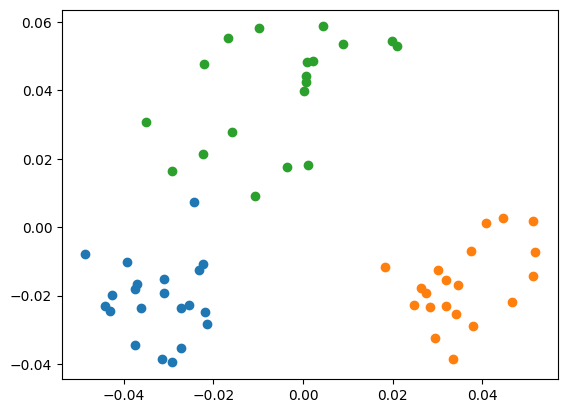

In [54]:
for i in range(len(set(label))):
    index = np.where(label == i)[0]
    plt.scatter(G_embedded[index,0], G_embedded[index,1], )
plt.show

In [93]:
def SBM_spectrum_experiment(subgroup_number, repetition):

    random_error_ave = []
    PS_error_ave = []
    WHOMP_random_error_ave = []
    WHOMP_matching_error_ave = []

    random_error_std = []
    PS_error_std = []
    WHOMP_random_error_std = []
    WHOMP_matching_error_std = []
    
    for s in range(repetition):

        sizes = [10, 20, 30]
        probs = [[0.6, 0.2, 0.2], [0.2, 0.6, 0.2], [0.2, 0.2, 0.6]]
        G = nx.stochastic_block_model(sizes, probs, seed=0)
        spec_0 = nx.laplacian_spectrum(G)
        density_0 = np.ones(len(spec_0))/len(spec_0)
        adj_matrix = nx.to_numpy_array(G)
        G_embedded = spectral_embedding(adj_matrix, n_components=2, random_state=42, norm_laplacian=True)
        shuffle_index = np.arange(subgroup_number)

        barycenter, barysample_index = WHOMP_LP(G_embedded, subgroup_number , 0.0000001)
        np.random.shuffle(shuffle_index)
        error = []
        for i in range(subgroup_number):
            subgraph = G.subgraph(barysample_index[shuffle_index[i]])
            spec_1 = nx.laplacian_spectrum(subgraph)
            density_1 = np.ones(len(spec_1))/len(spec_1)
            cost_matrix = ot.dist(spec_0.reshape((len(spec_0),1)), spec_1.reshape((len(spec_1),1)))
            plan = np.array(ot.emd(density_0,density_1,cost_matrix))
            error.append(np.sqrt(np.sum(plan*cost_matrix)))
        error_ave = np.average(error)
        error_std = np.std(error)
        WHOMP_matching_error_ave.append(error_ave)
        WHOMP_matching_error_std.append(error_std)


        anti_index = RandomAntiClustering_Exact(G_embedded, subgroup_number=subgroup_number)
        np.random.shuffle(shuffle_index)
        error = []
        for i in range(subgroup_number):
            subgraph = G.subgraph(np.where(anti_index == shuffle_index[i])[0])
            spec_1 = nx.laplacian_spectrum(subgraph)
            density_1 = np.ones(len(spec_1))/len(spec_1)
            cost_matrix = ot.dist(spec_0.reshape((len(spec_0),1)), spec_1.reshape((len(spec_1),1)))
            plan = np.array(ot.emd(density_0,density_1,cost_matrix))
            error.append(np.sqrt(np.sum(plan*cost_matrix)))
        error_ave = np.average(error)
        error_std = np.std(error)
        WHOMP_random_error_ave.append(error_ave)
        WHOMP_random_error_std.append(error_std)

        PS_index = Pocock_Simon_minimization(G_embedded, subgroup_number)
        np.random.shuffle(shuffle_index)
        error = []
        for i in range(subgroup_number):
            subgraph = G.subgraph(np.where(PS_index == shuffle_index[i])[0])
            spec_1 = nx.laplacian_spectrum(subgraph)
            density_1 = np.ones(len(spec_1))/len(spec_1)
            cost_matrix = ot.dist(spec_0.reshape((len(spec_0),1)), spec_1.reshape((len(spec_1),1)))
            plan = np.array(ot.emd(density_0,density_1,cost_matrix))
            error.append(np.sqrt(np.sum(plan*cost_matrix)))
        error_ave = np.average(error)
        error_std = np.std(error)
        PS_error_ave.append(error_ave)
        PS_error_std.append(error_std)

        random_index = RandomPartition(G_embedded, subgroup_number=subgroup_number)
        np.random.shuffle(shuffle_index)
        error = []
        for i in range(subgroup_number):
            subgraph = G.subgraph(np.where(random_index == shuffle_index[i])[0])
            spec_1 = nx.laplacian_spectrum(subgraph)
            density_1 = np.ones(len(spec_1))/len(spec_1)
            cost_matrix = ot.dist(spec_0.reshape((len(spec_0),1)), spec_1.reshape((len(spec_1),1)))
            plan = np.array(ot.emd(density_0,density_1,cost_matrix))
            error.append(np.sqrt(np.sum(plan*cost_matrix)))
        error_ave = np.average(error)
        error_std = np.std(error)
        random_error_ave.append(error_ave)
        random_error_std.append(error_std)

    random_ave = [np.average(random_error_ave), np.std(random_error_ave)]
    PS_ave = [np.average(PS_error_ave), np.std(PS_error_ave)]
    WHOMP_random_ave = [np.average(WHOMP_random_error_ave), np.std(WHOMP_random_error_ave)]
    WHOMP_matching_ave = [np.average(WHOMP_matching_error_ave), np.std(WHOMP_matching_error_ave)]

    random_std = [np.average(random_error_std), np.std(random_error_std)]
    PS_std = [np.average(PS_error_std), np.std(PS_error_std)]
    WHOMP_random_std = [np.average(WHOMP_random_error_std), np.std(WHOMP_random_error_std)]
    WHOMP_matching_std = [np.average(WHOMP_matching_error_std), np.std(WHOMP_matching_error_std)]

    Ave_list = [random_ave, PS_ave, WHOMP_random_ave, WHOMP_matching_ave]
    Std_list = [random_std, PS_std, WHOMP_random_std, WHOMP_matching_std]
    
    return Ave_list, Std_list


In [97]:
Ave_list, Std_list = SBM_spectrum_experiment(2, 50)

## 2 Subgroups

In [98]:
Ave_list

[[11.071990655823727, 0.30666832388628845],
 [11.108264974504015, 0.3531683269445331],
 [11.275257400085358, 0.3055627200167952],
 [11.285786845936999, 0.19970004915668169]]

In [99]:
Std_list

[[0.5997595818601472, 0.4288867808842967],
 [0.5061209097078558, 0.32987030276454365],
 [0.3981414171681243, 0.3030799691095593],
 [0.40997103918315053, 0.21257348091935183]]

## 6 subgroups

In [95]:
Ave_list

[[18.525234951841142, 0.2532710089668727],
 [18.591411618276638, 0.2930238079267556],
 [18.942140350084244, 0.22149900342034792],
 [19.05658492494176, 0.2492427110723422]]

In [96]:
Std_list

[[0.5829933191444856, 0.1680260678717264],
 [0.6225685830198944, 0.21863145677292675],
 [0.5235156127395877, 0.16744053817749885],
 [0.43776060044832027, 0.13605018773631367]]

## 4 subgroups

In [91]:
Ave_list

[[16.703914616709618, 0.33064026052185475],
 [16.688822072983633, 0.28891685396100497],
 [17.04224930601647, 0.26157693853332975],
 [16.563064819927806, 0.20585125589170197]]

In [92]:
Std_list

[[0.5724340691145823, 0.2511140208785977],
 [0.6451405033638403, 0.25321807653603745],
 [0.5724704265523468, 0.24124895841217758],
 [0.45509360892392786, 0.18203567182356645]]